In [194]:
from torch_geometric.datasets import Planetoid
from torch_geometric.data.data import Data
import torch_geometric
import torch
import networkx as nx
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

In [260]:
edge_index = torch.tensor([
    [0, 1, 1, 2, 3, 1, 0],
    [1, 0, 2, 1, 1, 3, 0]
], dtype=torch.long)

# Define node features (4 nodes, each with 3 features)
x = torch.tensor([[0],[1], [2], [3]], dtype=torch.float)

# Create a PyTorch Geometric data object
data_tg = Data(x=x, edge_index=edge_index)

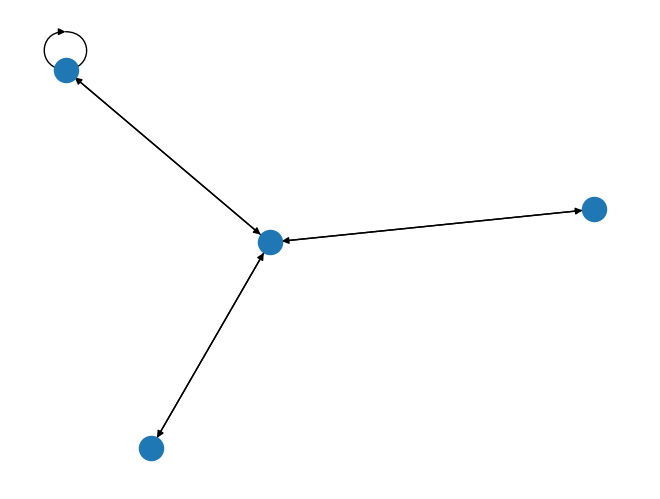

In [261]:
o = torch_geometric.utils.to_networkx(data_tg)
nx.draw(o)

In [262]:
data_tg.is_directed()

False

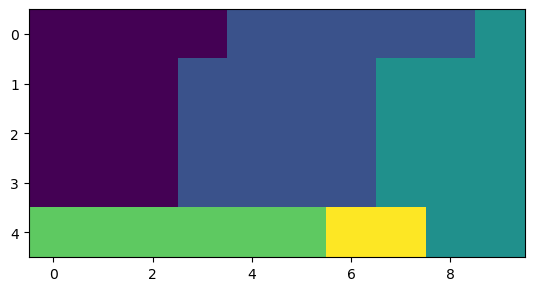

In [263]:
seg = np.array([[1, 1, 1, 1, 2, 2, 2, 2, 2, 3], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3], [4, 4, 4, 4, 4, 4, 5, 5, 3, 3]])
plt.imshow(seg)

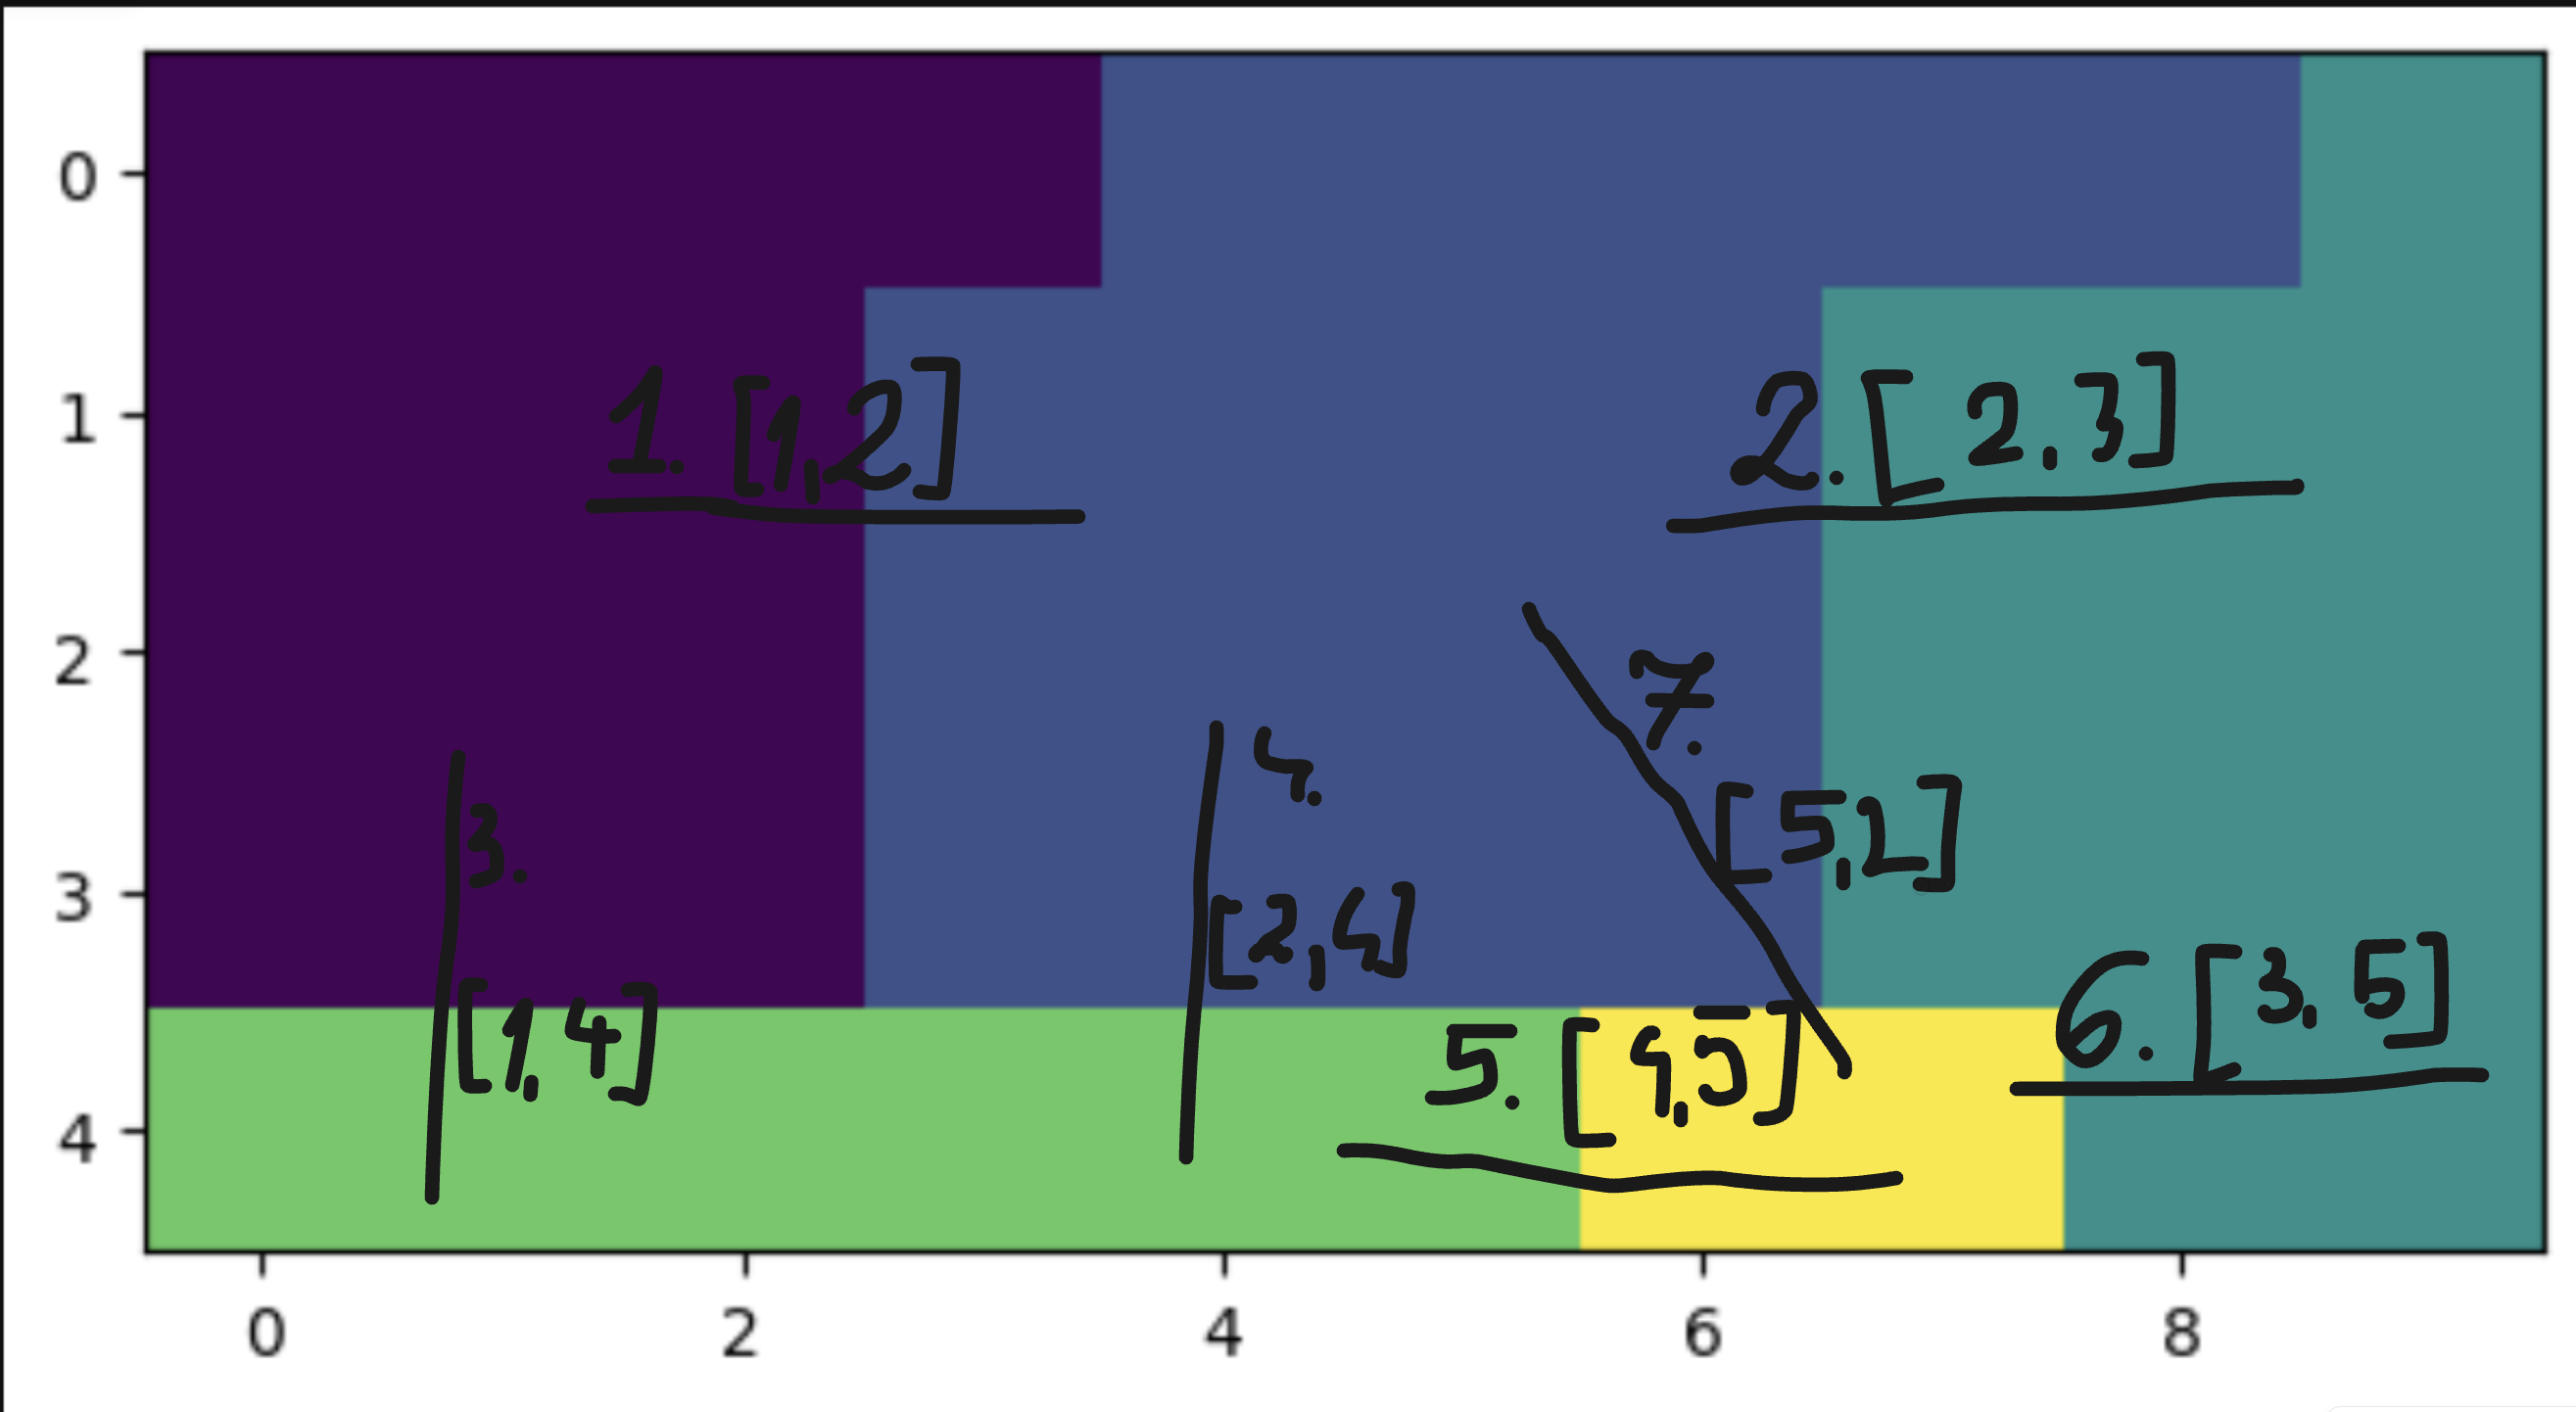

In [264]:
l2r = np.c_[seg[:, :-1].ravel(), seg[:, 1:].ravel()]
t2b = np.c_[seg[:-1, :].ravel(), seg[1:, :].ravel()]

edges = np.vstack([l2r, t2b])
edges = edges[edges[:, 0] != edges[:, 1], :]
edges = np.unique(np.sort(edges, axis=1), axis=0)
edges

array([[1, 2],
       [1, 4],
       [2, 3],
       [2, 4],
       [2, 5],
       [3, 5],
       [4, 5]])

In [265]:
edges.T

array([[1, 1, 2, 2, 2, 3, 4],
       [2, 4, 3, 4, 5, 5, 5]])

In [279]:
objects = []
with (open("data.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
data = objects[0]
segments = data["superpixels"]

In [280]:
l2r = np.c_[segments[:, :-1].ravel(), segments[:, 1:].ravel()]
t2b = np.c_[segments[:-1, :].ravel(), segments[1:, :].ravel()]

edges = np.vstack([l2r, t2b])
edges = edges[edges[:, 0] != edges[:, 1], :]
edges = np.unique(np.sort(edges, axis=1), axis=0)
coo_format = torch.tensor(edges.T) - 1
coo_format

tensor([[0, 0, 0, 1, 2, 3],
        [1, 2, 3, 2, 3, 4]])

In [281]:
data_graph = Data(x=torch.tensor([[1], [2], [3], [4], [5]]), edge_index=coo_format)
data_graph.num_nodes

5

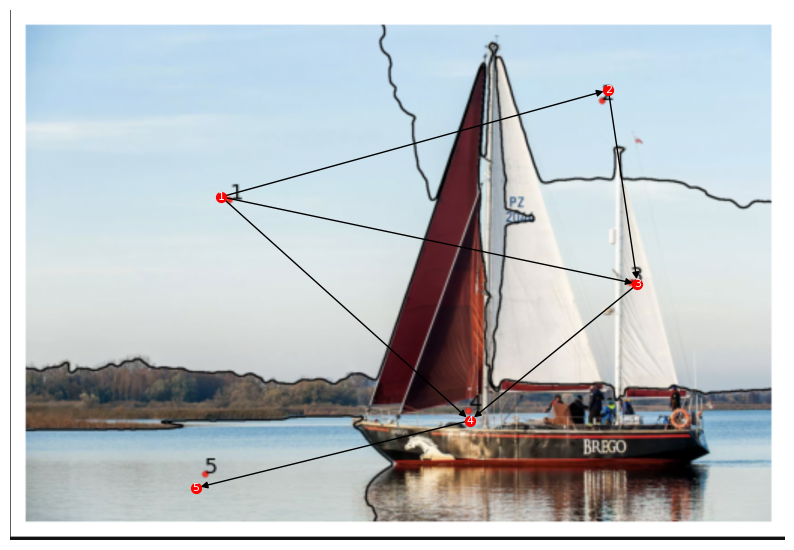

In [282]:
o = torch_geometric.utils.to_networkx(data_graph)
bg = io.imread("regions_img.png")

pos = {k: (v[0], v[1]) for k, v in data["centers"].items()}  
orig_h, orig_w = data["img"].shape[:2]
bg_h, bg_w = bg.shape[:2]

# Scale factors
scale_y = bg_h / orig_h
scale_x = bg_w / orig_w

# Rescale positions
pos_scaled = {k: (v[0] * scale_x, v[1] * scale_y) for k, v in data["centers"].items()}

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(bg)

# Draw graph on top of image
nx.draw(o, pos=pos_scaled, ax=ax, node_color="red", node_size=50)
nx.draw_networkx_labels(o, pos=pos_scaled, labels={i: i+1 for i in range(len(pos))},
                        font_color="white", font_size=8, ax=ax)

# Turn off axis ticks
# ax.axis("off")
plt.show()

In [144]:
data["centers"]

{1: (380.2614610695725, 442.0062361421186),
 2: (162.68858338791878, 1252.3559503458853),
 3: (557.8065188089695, 1313.3505326515988),
 4: (835.96849538814, 962.9291684303414),
 5: (973.2242018146379, 388.47721738913833)}

In [259]:
def unpickle(file):
    with open(f"cifar-10-batches-py/{file}", 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_

dicts = []
for f in os.listdir("cifar-10-batches-py"):
    if f.startswith("data"):
        dicts.append(unpickle(f))
meta = unpickle("batches.meta")
label_map = meta[b"label_names"]

In [257]:
X = np.concatenate([i[b'data'] for i in dicts], axis=0)
X = X.reshape(-1, 3, 32, 32)
X = X.transpose(0, 2, 3, 1)
y = np.concatenate([i[b'labels'] for i in dicts], axis=0)

In [258]:
X.shape, y.shape

((50000, 32, 32, 3), (50000,))

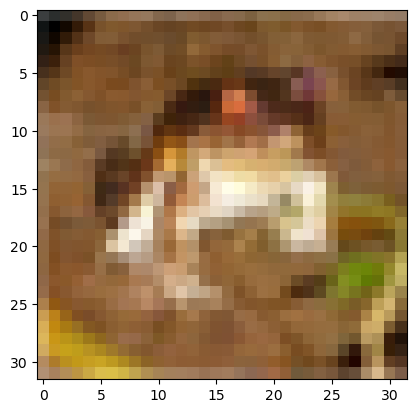

In [255]:
plt.imshow(X[0])

3072